In [1]:
%pip install scikits-bootstrap --user
%pip install pymicro --user
%pip install vtk --user

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load data

In [3]:
info1 = pd.read_excel('Table_biasedODR_info.xlsx')
info2 = pd.read_excel('Table_biasedODR_info.xlsx', sheet_name=1)

In [4]:
info1.rename(columns={
    'delay period': 'delay',
    'number of classes ': 'n_classes',
    'number of trials': 'n_trials',
    'correct trials': 'corr_trials'
},
             inplace=True)
info1

,filename,delay,n_classes,n_trials,corr_trials,performance
0,vmmtest01,1.5,72,301,301,1.000000
1,vmmtest02,1.5,72,298,275,0.922819
2,vmmtest03,1.5,72,239,235,0.983264
3,vmmtest04,1.5,72,320,313,0.978125
4,vmmtest05,1.5,72,24,19,0.791667
5,vmm120_1,1.5,120,333,327,0.981982
6,vmm120_2,1.5,120,349,347,0.994269
7,vmm1203_1,3.0,120,126,121,0.960317
8,vmm1203_2,3.0,120,137,133,0.970803


In [5]:
info2

,Statecode,Unnamed: 1,Stimulus Class,Cue location,Saccadic Endpoint X,Saccadic Endpoint Y,Unnamed: 6
0,6,Correct,(Internal Variable),"(true position, in degrees)",NaN,NaN,Aborted
1,5,"Completed, incorrect",NaN,NaN,NaN,0.0,Indeterminate
2,1-4,Aborted,NaN,NaN,NaN,NaN,NaN


In [6]:
calib = pd.read_excel('calibration_result_SL.xlsx')
calib

,angle,X_1,X_2,X_3,X_4,X_5,Y_1,Y_2,Y_3,Y_4,Y_5
0,0,9.927509,9.789701,10.721368,10.993732,9.354796,0.962013,0.299778,0.788224,0.800760,0.321178
1,45,5.007123,4.679725,5.363960,5.886515,3.764799,6.789649,6.940646,6.810304,7.793210,5.329218
2,90,-2.604938,-1.915005,-2.029018,-4.361651,-3.681481,8.866097,7.773504,7.881714,8.652594,6.132764
3,135,-9.479266,-8.312631,-8.210721,-10.770526,-9.357075,4.635328,3.327066,4.073758,4.397393,2.653561
4,180,-11.146882,-10.421415,-9.636040,-12.637987,-10.599620,-2.686610,-3.190883,-3.172602,-2.651662,-4.471605
5,225,-6.618867,-6.085090,-5.259972,-7.514087,-6.735992,-9.121557,-9.744349,-10.312915,-9.508600,-10.736942
6,270,2.077556,1.364198,2.609008,1.080405,0.503134,-9.546375,-12.076448,-12.345815,-11.924343,-12.892118
7,315,9.170307,8.074549,9.372541,8.937955,6.817664,-6.066160,-8.547721,-8.270113,-7.795610,-8.664451


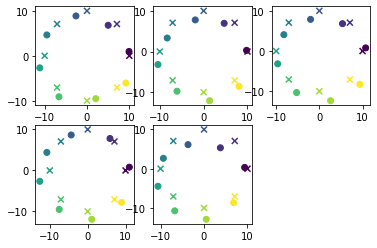

In [7]:
for i in range(5):
    plt.subplot(2,3,i+1)
    x=calib['X_'+str(i+1)]
    y=calib['Y_'+str(i+1)]
    plt.scatter(x,y,c=calib.angle)
    plt.scatter(10*np.cos(np.deg2rad(calib.angle)), 10*np.sin(np.deg2rad(calib.angle)), c=calib.angle, marker='x')

We now register the eye tracker data to the reference targets using the recipe in https://pymicro.readthedocs.io/projects/pymicro/en/latest/cookbook/pointset_registration.html

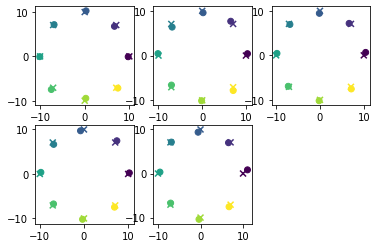

In [8]:
from pymicro.view.vol_utils import compute_affine_transform
# compute the affine transform from the point set
transf=[]
ref_centr=[]
tsr_centr=[]

ref_points = np.array([[10*np.cos(np.deg2rad(calib.angle[i])), 10*np.sin(np.deg2rad(calib.angle[i]))] for i in range(8)])
for i in range (5):
    plt.subplot(2,3,i+1)
    x=calib['X_'+str(i+1)]
    y=calib['Y_'+str(i+1)]
    tsr_points = np.array([[x[j], y[j]] for j in range(8)])
    
    # get the affine transformations that map eye tracker data to reference points
    translation, transformation = compute_affine_transform(ref_points, tsr_points)
    
    transf.append(transformation) #save for transformation of data points later
    
    # now get the centroid in each condition for recentering
    ref_centroid = np.mean(ref_points, axis=0)
    tsr_centroid = np.mean(tsr_points, axis=0)
    ref_centr.append(ref_centroid) #save for transformation of data points later
    tsr_centr.append(tsr_centroid) #save for transformation of data points later
    
    # remap the eye tracker data using the transformation
    new_points = np.empty_like(ref_points)
    for j in range(8):
        new_points[j] = ref_centroid + np.dot(transformation, tsr_points[j] - tsr_centroid)

    # visualize the match
    plt.scatter(new_points[:,0], new_points[:,1], c=calib.angle)
    plt.scatter(ref_points[:,0], ref_points[:,1], c=calib.angle, marker='x')


Now load behavioral data, concatenating the various sessions and appending the info contained in **info1**. Discard the first data file because it is not available. For each session, realign based on affine transformations obtained above from the calibration data

In [9]:
nsess = info1.shape[0]
lst = []
for i in range(nsess - 1):
    dat = pd.read_csv(info1.loc[i + 1, 'filename'] + '.csv',
                      names=['Statecode', 'StimClass', 'Cue', 'X0', 'Y0'])
    ndat = dat.shape[0]
    appnd = pd.DataFrame(info1.iloc[i + 1].values.repeat(ndat, axis=0).reshape((6, ndat)).T, columns=info1.columns)
    
    # here we realign eye tracking data using the tracker calibration 
    new_points = np.empty((ndat,2))
    for j in range(ndat):
#        new_points[j] = ref_centr[i] + np.dot(transf[i], [dat.loc[j,'X0'], dat.loc[j,'Y0']] - tsr_centr[i])
        calb=1
        new_points[j] = ref_centr[calb] + np.dot(transf[calb], [dat.loc[j,'X0'], dat.loc[j,'Y0']] - tsr_centr[calb])
    conv = pd.DataFrame(new_points, columns=['X','Y'])
                                                          
    mrgd = pd.concat([dat, conv, appnd], axis=1, join="inner")
    lst.append(mrgd)

data = pd.concat(lst, ignore_index=True)

In [10]:
data


,Statecode,StimClass,Cue,X0,Y0,X,Y,filename,delay,n_classes,n_trials,corr_trials,performance
0,6.0,2.0,5.0,8.910731,3.450142,10.058249,3.604742,vmmtest02,1.5,72,298,275,0.922819
1,6.0,43.0,210.0,-8.891738,-5.607787,-9.050745,-2.139968,vmmtest02,1.5,72,298,275,0.922819
2,6.0,51.0,250.0,-1.385565,-7.199430,-1.962414,-4.928881,vmmtest02,1.5,72,298,275,0.922819
3,6.0,48.0,235.0,-5.596391,-6.566952,-5.985460,-3.615144,vmmtest02,1.5,72,298,275,0.922819
4,6.0,15.0,70.0,2.035138,10.120608,4.498621,11.179509,vmmtest02,1.5,72,298,275,0.922819
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121,6.0,115.0,342.0,8.485280,1.100665,9.219692,1.413171,vmm1203_2,3,120,137,133,0.970803
3122,2.0,NaN,NaN,NaN,NaN,NaN,NaN,vmm1203_2,3,120,137,133,0.970803
3123,4.0,NaN,NaN,NaN,NaN,NaN,NaN,vmm1203_2,3,120,137,133,0.970803
3124,6.0,6.0,15.0,8.857550,6.462488,10.545324,6.514805,vmm1203_2,3,120,137,133,0.970803


### Define helper functions

In [11]:
from scipy.stats import circmean,circvar,circstd

def circdist(angles1,angles2): #define the name and set the arguments between parentheses
    output = np.angle( np.exp(1j*(angles1-angles2))) ## mathematical operation to get the circular distance
    return output #return the circular distance in radians 

def circ_mean(x):
    return circmean(x,high=np.pi,low=-np.pi)


def compute_serial(report,target,d,xxx):
    err=circdist(report,target)
    idx_clean=(np.abs(err)<10*np.std((err)))
    err=err[idx_clean]
    d=d[idx_clean]
    m_err=[]
    std_err=[]
    count=[]
    cis=[]
    err = np.sign(d)*err
    d=np.abs(d)
    points_idx=[]
    for t in xxx:
        idx=(d>t)&(d<=t+w2)
        m_err.append(circ_mean(err[idx]))
        std_err.append(circstd(err[idx])/np.sqrt(sum(idx)))
        count.append(sum(idx))
        points_idx.append(idx)
    return np.array(err),d,np.array(m_err),np.array(std_err),count,points_idx



### Generate table with consecutive correct trials and previous/current cues

In [12]:
ntrials = data.shape[0]
data_seq = data.copy()
# go through correct trials and include cue of previous trial, if correct. Otherwise, include NaN
for i in range(ntrials - 1):
    if (data_seq.loc[i,
                     'Statecode'] == 6) and (data_seq.loc[i + 1,
                                                          'Statecode'] == 6):
        data_seq.loc[i + 1, 'PrevCue'] = data_seq.loc[i, 'Cue']
    else:
        data_seq.loc[i + 1, 'PrevCue'] = np.nan

# remove trials that are not correct and are not preceded by correct
data_seq.drop(index=np.where(np.isnan(data_seq['PrevCue']))[0], inplace=True)
data_seq.reset_index(drop=True, inplace=True)

# remove trials for which X=0 and Y=0
modulus = data_seq['X0']**2 + data_seq['Y0']**2
data_seq.drop(index=np.where(modulus == 0)[0], inplace=True)
data_seq.reset_index(drop=True, inplace=True)

# add columns with relevant calculations, in radians
data_seq['prev_curr'] = circdist(np.deg2rad(data_seq['PrevCue']),
                                 np.deg2rad(data_seq['Cue']))
data_seq['ang_sacc'] = np.arctan2(data_seq['Y'], data_seq['X'])
data_seq['ang_cue'] = np.deg2rad(data_seq['Cue'])
data_seq['error'] = circdist(data_seq['ang_sacc'], data_seq['ang_cue'])

In [13]:
data_seq

,Statecode,StimClass,Cue,X0,Y0,X,Y,filename,delay,n_classes,n_trials,corr_trials,performance,PrevCue,prev_curr,ang_sacc,ang_cue,error
0,6.0,43.0,210.0,-8.891738,-5.607787,-9.050745,-2.139968,vmmtest02,1.5,72,298,275,0.922819,5.0,2.705260,-2.909415,3.665191,-0.291422
1,6.0,51.0,250.0,-1.385565,-7.199430,-1.962414,-4.928881,vmmtest02,1.5,72,298,275,0.922819,210.0,-0.698132,-1.949703,4.363323,-0.029841
2,6.0,48.0,235.0,-5.596391,-6.566952,-5.985460,-3.615144,vmmtest02,1.5,72,298,275,0.922819,250.0,0.261799,-2.598246,4.101524,-0.416585
3,6.0,15.0,70.0,2.035138,10.120608,4.498621,11.179509,vmmtest02,1.5,72,298,275,0.922819,235.0,2.879793,1.188224,1.221730,-0.033507
4,6.0,31.0,150.0,-13.020893,2.849953,-11.592571,6.696544,vmmtest02,1.5,72,298,275,0.922819,130.0,-0.349066,2.617763,2.617994,-0.000231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,6.0,91.0,270.0,1.146249,-5.731244,0.787435,-3.938534,vmm1203_2,3,120,137,133,0.970803,264.0,-0.104720,-1.373467,4.712389,0.197329
1124,6.0,65.0,192.0,-10.418803,-1.866097,-9.880883,1.719148,vmm1203_2,3,120,137,133,0.970803,153.0,-0.680678,2.969330,3.351032,-0.381702
1125,6.0,88.0,261.0,-0.194682,-6.061728,-0.588925,-4.032441,vmm1203_2,3,120,137,133,0.970803,96.0,-2.879793,-1.715818,4.555309,0.012058
1126,6.0,48.0,141.0,-9.907882,5.647673,-8.033781,8.870102,vmm1203_2,3,120,137,133,0.970803,261.0,2.094395,2.306760,2.460914,-0.154155


In [14]:
print('trials with delay 1.5: ' + str(np.sum(data_seq['delay'] < 2)))
print('trials with delay 3: ' + str(np.sum(data_seq['delay'] > 2)))
print('trials with response modulus equals 0: ' + str(np.sum(modulus == 0)))

trials with delay 1.5: 982
trials with delay 3: 146
trials with response modulus equals 0: 127


### Precision of responses

(-60.0, 60.0)

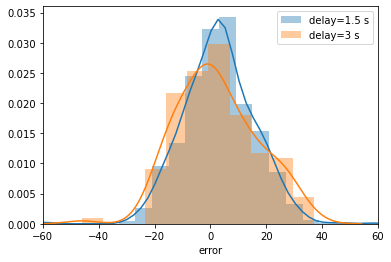

In [15]:
import seaborn as sns
#data_seq[['error','delay period']].groupby('delay period').hist(bins=100, density=True)

df = data_seq[data_seq['delay'] < 2]
sns.distplot(np.rad2deg(df['error']), kde=True, label='delay=1.5 s')
df = data_seq[data_seq['delay'] > 2]
sns.distplot(np.rad2deg(df['error']), kde=True, label='delay=3 s')
plt.legend()
plt.xlim([-60, 60])

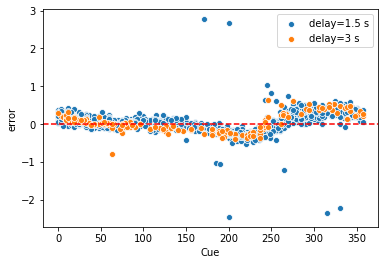

In [16]:
df = data_seq[data_seq['delay'] < 2]
sns.scatterplot(x='Cue', y='error', data=df, label='delay=1.5 s')
df = data_seq[data_seq['delay'] > 2]
sns.scatterplot(x='Cue', y='error', data=df, label='delay=3 s')
plt.axhline(color='r', linestyle='--')
plt.legend()

### Serial bias

In [17]:
w1 = np.pi / 50  #100
w2 = np.pi / 5  #10
n_perms = 1000
xxx2 = np.arange(0, np.pi - w2 + w1, w1)

err,d,m_err,std_err,count,points_idx = \
    compute_serial(data_seq['ang_sacc'], data_seq['ang_cue'], data_seq['prev_curr'], xxx2)

Error bars by bootstrap:

In [18]:
import multiprocessing
from joblib import Parallel, delayed
import scikits.bootstrap as bootstrap

num_cores = multiprocessing.cpu_count()
boot_idx = bootstrap.bootstrap_indexes(data_seq['ang_sacc'], n_samples=n_perms)


def one_boot(i):
    err,d,m_err,std_err,count,points_idx = \
        compute_serial(data_seq.loc[i,'ang_sacc'],data_seq.loc[i,'ang_cue'],data_seq.loc[i,'prev_curr'],xxx2)
    return m_err


M = Parallel(n_jobs=num_cores)(delayed(one_boot)(i) for i in boot_idx)

In [19]:
stderr = np.std(M, 0)
shuf_mean = np.mean(M, 0)

down = (m_err - stderr)
up = (m_err + stderr)

Plot:

Text(0, 0.5, 'folded angle saccade error (deg)')

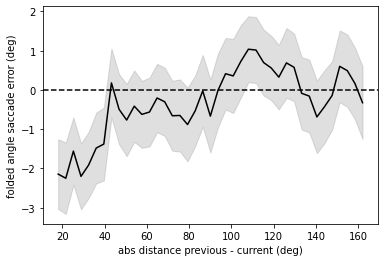

In [20]:
plt.fill_between(np.rad2deg(xxx2 + w2 / 2),
                 np.rad2deg(down),
                 np.rad2deg(up),
                 color="gray",
                 alpha=0.25)
plt.plot(np.rad2deg(xxx2 + w2 / 2), np.rad2deg(m_err), "k-", lw=1.5)
plt.axhline(linestyle='--', color='k')
plt.xlabel('abs distance previous - current (deg)')
plt.ylabel('folded angle saccade error (deg)')

In [21]:
import scipy.stats as sps


def serial_bias(prevcurr, error, window, step):
    xxx = np.arange(-np.pi, np.pi, step)
    m_err = []
    std_err = []
    for t in xxx:
        idx = (prevcurr >= t - window / 2) & (prevcurr < t + window / 2)
        if t - window / 2 < -np.pi:
            idx = (prevcurr >= t - window / 2) & (
                prevcurr < t + window / 2) | (prevcurr > np.pi -
                                              (window / 2 -
                                               (np.pi - np.abs(t))))
        if t + window / 2 > np.pi:
            idx = (prevcurr >= t - window / 2) & (
                prevcurr < t + window / 2) | (prevcurr < -np.pi +
                                              (window / 2 -
                                               (np.pi - np.abs(t))))
        m_err.append(sps.circmean(error[idx], low=-np.pi, high=np.pi))
        std_err.append(sps.circstd(error[idx]) / np.sqrt(np.sum(idx)))
    return np.array(m_err), np.array(std_err)


def folded_bias(prevcurr, error, window, step):
    xxx = np.arange(-np.pi, np.pi, step)
    t_err = []
    err = []
    for t in xxx:
        idx = (prevcurr >= t - window / 2) & (prevcurr < t + window / 2)
        if t - window / 2 < -np.pi:
            idx = (prevcurr >= t - window / 2) & (
                prevcurr < t + window / 2) | (prevcurr > np.pi -
                                              (window / 2 -
                                               (np.pi - np.abs(t))))
        if t + window / 2 > np.pi:
            idx = (prevcurr >= t - window / 2) & (
                prevcurr < t + window / 2) | (prevcurr < -np.pi +
                                              (window / 2 -
                                               (np.pi - np.abs(t))))
        t_err.append(list(error[idx]))
    for t in reversed(range(int(len(xxx) / 2))):
        err.append([x * -1 for x in t_err[t]] + t_err[-t - 1])
    m_err = [sps.circmean(x, low=-np.pi, high=np.pi) for x in err]
    se_err = [sps.circstd(x) / np.sqrt(len(x)) for x in err]
    return np.array(m_err), np.array(se_err)

In [22]:
# this makes surrogate data with an attractive bias towards previous cue, for check purposes
#data_seq['error']=0.2*np.random.randn(len(data_seq)) + 0.05*data_seq['prev_curr']

import scipy.signal as ss
# serial bias parameters for sliding average
window = np.pi / 3
step = np.pi / 30
#sb = folded_bias(data_seq.prev_curr, ss.detrend(data_seq.error),window,step)[0]
sb = folded_bias(data_seq.prev_curr, data_seq.error, window, step)[0]
xsb = np.arange(0, np.pi, step)

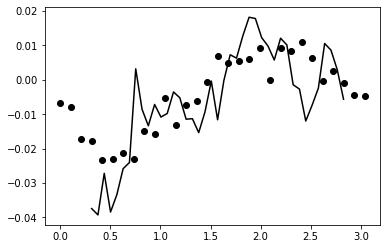

In [23]:
plt.plot(xsb, sb,'ko')
plt.plot(xxx2+w2/2, m_err,"k-",lw=1.5)


Now serial bias separately for long and short delays:

Text(0, 0.5, 'angle saccade error (deg)')

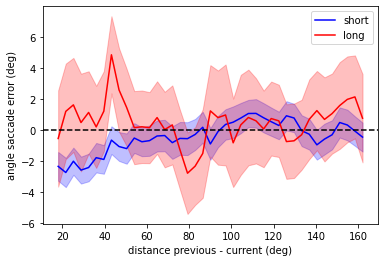

In [24]:
data_sl = data_seq.loc[data_seq['delay'] == 1.5].copy()
data_sl = data_sl.reset_index(drop=True)
err, d, m_err, std_err, count, points_idx = compute_serial(
    data_sl['ang_sacc'], data_sl['ang_cue'], data_sl['prev_curr'], xxx2)
plt.plot(np.rad2deg(xxx2 + w2 / 2),
         np.rad2deg(m_err),
         "b-",
         lw=1.5,
         label='short')
boot_idx = bootstrap.bootstrap_indexes(data_sl['ang_sacc'], n_samples=n_perms)


def one_boot(i):
    err, d, m_err, std_err, count, points_idx = compute_serial(
        data_sl.loc[i, 'ang_sacc'], data_sl.loc[i, 'ang_cue'],
        data_sl.loc[i, 'prev_curr'], xxx2)
    return m_err


M = Parallel(n_jobs=num_cores)(delayed(one_boot)(i) for i in boot_idx)
stderr = np.std(M, 0)
shuf_mean = np.mean(M, 0)

down = (m_err - stderr)
up = (m_err + stderr)
plt.fill_between(np.rad2deg(xxx2 + w2 / 2),
                 np.rad2deg(down),
                 np.rad2deg(up),
                 color="b",
                 alpha=0.25)

data_sl = data_seq.loc[data_seq['delay'] > 1.5].copy()
data_sl = data_sl.reset_index(drop=True)
err, d, m_err, std_err, count, points_idx = compute_serial(
    data_sl['ang_sacc'], data_sl['ang_cue'], data_sl['prev_curr'], xxx2)
plt.plot(np.rad2deg(xxx2 + w2 / 2),
         np.rad2deg(m_err),
         "r-",
         lw=1.5,
         label='long')
boot_idx = bootstrap.bootstrap_indexes(data_sl['ang_sacc'], n_samples=n_perms)


def one_boot(i):
    err, d, m_err, std_err, count, points_idx = compute_serial(
        data_sl.loc[i, 'ang_sacc'], data_sl.loc[i, 'ang_cue'],
        data_sl.loc[i, 'prev_curr'], xxx2)
    return m_err


M = Parallel(n_jobs=num_cores)(delayed(one_boot)(i) for i in boot_idx)
stderr = np.std(M, 0)
shuf_mean = np.mean(M, 0)

down = (m_err - stderr)
up = (m_err + stderr)
plt.fill_between(np.rad2deg(xxx2 + w2 / 2),
                 np.rad2deg(down),
                 np.rad2deg(up),
                 color="r",
                 alpha=0.25)

plt.axhline(linestyle='--', color='k')
plt.legend()
plt.xlabel('distance previous - current (deg)')
plt.ylabel('angle saccade error (deg)')

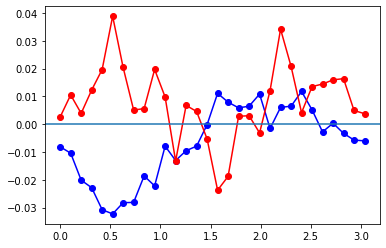

In [25]:
# serial bias parameters for sliding average
window = np.pi / 3
step = np.pi / 30
sb_sh = folded_bias(data_seq.prev_curr[data_seq.delay < 2],
                    data_seq.error[data_seq.delay < 2], window, step)[0]
sb_lg = folded_bias(data_seq.prev_curr[data_seq.delay > 2],
                    data_seq.error[data_seq.delay > 2], window, step)[0]
xsb = np.arange(0, np.pi, step)
plt.plot(xsb, sb_sh, 'bo-')
plt.plot(xsb, sb_lg, 'ro-')
plt.axhline()

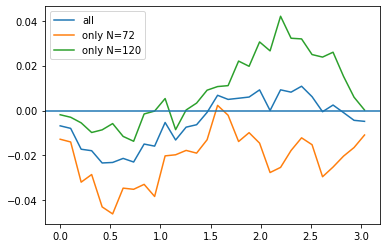

In [38]:
# serial bias parameters for sliding average
window = np.pi / 3
step = np.pi / 30
sb_all = folded_bias(data_seq.prev_curr,
                    data_seq.error, window, step)[0]
sb_n72 = folded_bias(data_seq.prev_curr[data_seq.n_classes==72],
                    data_seq.error[data_seq.n_classes==72], window, step)[0]
sb_n120 = folded_bias(data_seq.prev_curr[data_seq.n_classes==120],
                    data_seq.error[data_seq.n_classes==120], window, step)[0]
xsb = np.arange(0, np.pi, step)
plt.plot(xsb, sb_all, label='all')
plt.plot(xsb, sb_n72, label='only N=72')
plt.plot(xsb, sb_n120, label='only N=120')
plt.axhline()
plt.legend()

### Nonuniform cues

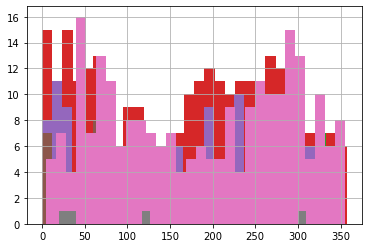

In [26]:
data_seq.groupby('filename').Cue.hist(bins=30);

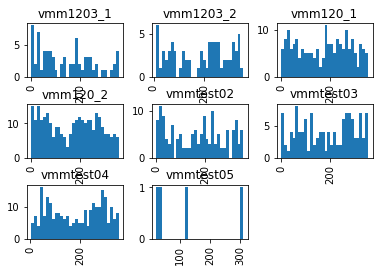

In [27]:
data_seq[['Cue','filename']].hist(by='filename', bins=30);

### regression model

In [28]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def normgauss(xxx, sigma):
    gauss = (1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(xxx - 0)**2 /
                                                       (2 * sigma**2)))
    return gauss / gauss.max()


def normgrad(xxx):
    return np.gradient(xxx) / np.gradient(xxx).max()


def dog1(sigma, x):
    xxx = np.arange(-2 * np.pi, 2 * np.pi, .0001)
    dog_1st = normgrad(normgauss(xxx, sigma))
    return np.array(list(map(lambda x: dog_1st[find_nearest(xxx, x)], x)))

In [29]:
par=0.5
x=np.linspace(0,np.pi,100)
tmp=dog1(par,x)

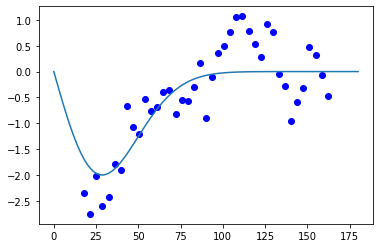

In [30]:
data_sl = data_seq.loc[data_seq['delay'] == 1.5].copy()
data_sl = data_sl.reset_index(drop=True)
err, d, m_err, std_err, count, points_idx = compute_serial(
    data_sl['ang_sacc'], data_sl['ang_cue'], data_sl['prev_curr'], xxx2)
plt.plot(np.rad2deg(xxx2 + w2 / 2),
         np.rad2deg(m_err),
         "bo",
         lw=1.5,
         label='short')

plt.plot(np.rad2deg(x), 2 * tmp)

In [31]:
# add DoG(prevcurr) to dataframe
# hyperparameter and DoG1 vs DoG3 from model_selection.py
data_seq['baseprevcurr']  = dog1(par, data_seq.prev_curr.values)

In [32]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

mod = smf.glm(formula='error ~ baseprevcurr*delay', data=data_seq)
res = mod.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  error   No. Observations:                 1128
Model:                            GLM   Df Residuals:                     1124
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                        0.079449
Method:                          IRLS   Log-Likelihood:                -170.15
Date:                Fri, 05 Mar 2021   Deviance:                       89.300
Time:                        16:22:25   Pearson chi2:                     89.3
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

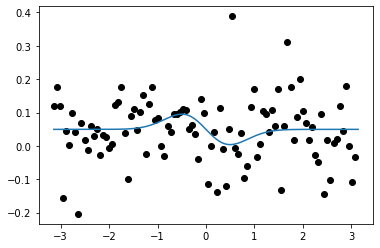

In [33]:
bins = np.linspace(-np.pi, np.pi, 100)
groups = data_seq.groupby(pd.cut(data_seq.prev_curr, bins))

plt.plot(bins[:-1], groups.error.mean(), 'ko')
#plt.xlim([-50, 50])

pc = np.linspace(-np.pi, np.pi, 200)
sbc = res.params['Intercept'] + res.params['baseprevcurr'] * dog1(par, pc)
plt.plot(pc, sbc)

In [34]:
np.sum(data_seq['Cue']==210)

13

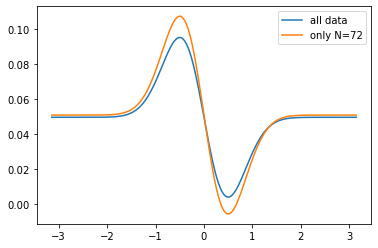

In [35]:
mod72 = smf.glm(formula='error ~ baseprevcurr', data=data_seq[data_seq.n_classes==72])
res72 = mod72.fit()

sbc = res.params['Intercept'] + res.params['baseprevcurr'] * dog1(par, pc)
plt.plot(pc, sbc, label='all data')
sbc72 = res72.params['Intercept'] + res72.params['baseprevcurr'] * dog1(par, pc)
plt.plot(pc, sbc72, label='only N=72')
plt.legend()